In [10]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [11]:
with open(fname) as f:
    data = f.read()

In [12]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [13]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1)) # data time is omitted
for i , line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i] = values[:]

In [14]:
temperature.shape

(420451,)

In [15]:
raw_data.shape

(420451, 14)

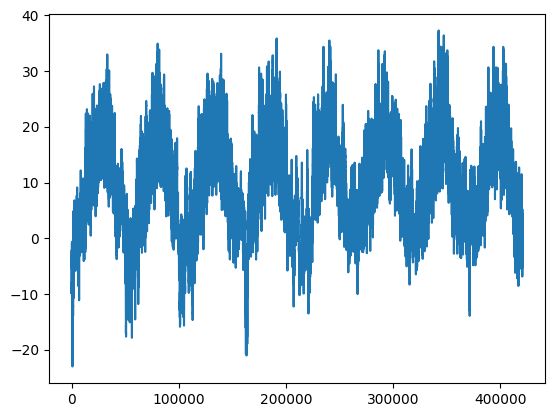

In [16]:
#plot the temperature
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)), temperature)

let us plot for first 10 days -> temp and other parameters are recorded every 10 minutes.so 24X6= 144 datapoints per day

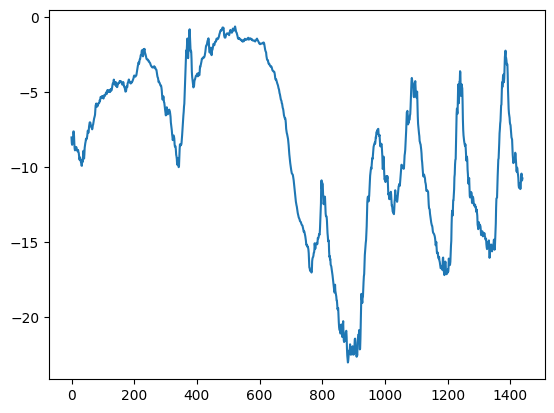

In [12]:
plt.plot(range(1440), temperature[:1440])

in the last four days, we can observe some perdiodicity. Natural phenomenon like these will exhibit periodicity. 
looking at the data will help choose the right model for the task at hand


In [17]:
num_train_samples=  int(0.5*len(raw_data))
val_train_samples = int(0.25*len(raw_data))
test_samples = len(raw_data) - num_train_samples - val_train_samples

In [18]:
print(num_train_samples, val_train_samples, test_samples)

210225 105112 105114


to make is easier for a neural network to ingest data, data normalization is done.


In [19]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

A quick run through of the keras utility function timeseries_dataset_from_array(). 

In [18]:
from tensorflow import keras
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2

)
for inputs,target in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(target[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


for our model, we will use data samples for 5 days with each sample data point taken once per hour. hence sample_rate = 6, every 6th point is taken for consideration
sequence_length = 24X5 = 120



In [20]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24-1)
batch_size=256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle=True,
    sequence_length = sequence_length,
    batch_size=batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
targets=temperature[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + val_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array( raw_data[:-delay],
targets=temperature[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size, start_index=num_train_samples + val_train_samples)

In [21]:
for samples, target in train_dataset:
    print(samples.shape)
    print(target.shape)
    break

(256, 120, 14)
(256,)


Common sense machinelearning baseline : It is always required to have a common sense baseline and the model is requried to beat this model atleast.

In [22]:
std.shape, mean.shape

((14,), (14,))

A naive prediction approach is to set the temperature after 24 hrs to be the same as the last observed temperature in the list of 120 inputs.

In [24]:
def evaluate_naive_method(dataset):
    total_abs_error = 0.
    num_samples = 0
    for samples, targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        num_samples += samples.shape[0]
        return total_abs_error / num_samples


In [25]:
print(f"for validation set, the MAE is {evaluate_naive_method(val_dataset):0.2f}")
print(f"for test set , the MAE is {evaluate_naive_method(test_dataset):0.2f}")


for validation set, the MAE is 2.54
for test set , the MAE is 2.63


A simple densely connected neural network 

In [26]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten() (inputs)
x = layers.Dense(16, activation='relu') (x)
outputs = layers.Dense(1) (x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [28]:
callback = [keras.callbacks.ModelCheckpoint('jena_dense.h5',save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callback)

Epoch 1/10


2024-03-24 17:45:06.427045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 11s 13ms/step - loss: 66.1484 - mae: 6.8033 - val_loss: 24.3680 - val_mae: 4.1257
Epoch 2/10
  7/819 [..............................] - ETA: 7s - loss: 26.7784 - mae: 4.3002  

/Users/divyeshkanagavel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 11s 13ms/step - loss: 33.9434 - mae: 4.2506 - val_loss: 10.5129 - val_mae: 2.5418
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 34.1012 - mae: 4.0615 - val_loss: 39.6810 - val_mae: 5.1967
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 31.4049 - mae: 4.0743 - val_loss: 10.3581 - val_mae: 2.5226
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 29.3875 - mae: 3.9752 - val_loss: 29.7454 - val_mae: 4.4466
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 28.8954 - mae: 4.1603 - val_loss: 25.9333 - val_mae: 4.1296
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 28.1430 - mae: 4.1108 - val_loss: 33.1447 - val_mae: 4.7206
Epoch 8/10
819/819 [==============================] - 11s 13ms/step - loss: 28.2208 - mae: 4.1511 - val_loss: 9.8715 - val_mae: 2.4638
Epoch 9/10
819/819 [==============================] - 11s 13

In [32]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
model = keras.models.load_model("jena_dense.h5") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 11.6267 - mae: 2.6872
Test MAE: 2.69


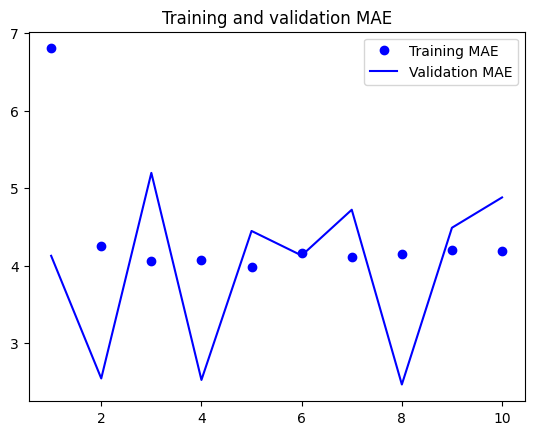

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

the densely connected network is not good at learning the underlying patterns in timeseries type of problems. We could try a temporal convnet similar to spatial convnet which could learn the periodic cycles present in the data and use that understanding to make predictions just like conv2D does for images.

convnet works great where there is translation invariance. that is a pattern observed in one place can be reused if found elsewhere.

Convnet1D

In [35]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2) (x)
x = layers.Conv1D(8, 12, activation="relu") (x)
x = layers.MaxPooling1D(2) (x)
x = layers.Conv1D(8, 6, activation="relu") (x)
x = layers.GlobalAveragePooling1D() (x)
outputs = layers.Dense(1) (x)
model = keras.Model(inputs = inputs, outputs = outputs)



In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [37]:
callbacks = [
            keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                            save_best_only=True)
        ]

In [38]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                            epochs=10,
                            validation_data=val_dataset,
                            callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 24.5271 - mae: 3.8590 - val_loss: 15.3917 - val_mae: 3.1168
Epoch 2/10
  5/819 [..............................] - ETA: 10s - loss: 17.2774 - mae: 3.3134 

/Users/divyeshkanagavel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 13s 16ms/step - loss: 15.9312 - mae: 3.1626 - val_loss: 14.7269 - val_mae: 3.0283
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.6248 - mae: 3.0301 - val_loss: 16.1884 - val_mae: 3.2000
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.7112 - mae: 2.9337 - val_loss: 14.3069 - val_mae: 2.9964
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 13.0399 - mae: 2.8569 - val_loss: 14.5742 - val_mae: 3.0019
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 12.5178 - mae: 2.7981 - val_loss: 18.3261 - val_mae: 3.3891
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 12.1283 - mae: 2.7521 - val_loss: 14.3679 - val_mae: 2.9860
Epoch 8/10
819/819 [==============================] - 13s 16ms/step - loss: 11.7959 - mae: 2.7130 - val_loss: 15.1126 - val_mae: 3.0802
Epoch 9/10
819/819 [==============================] - 13s 1

even the conv is not giving a good result achieving a val_loss of 3.6023

In [40]:
model = keras.models.load_model("jena_conv.h5") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 16.1579 - mae: 3.2146
Test MAE: 3.21


The data does not quite follow the translation invariance assumption. there is some periodicity in the data, but the data in the morning is quite different from the night data. this is not studied in the convnet1D. the order in the data matters a lot. 
the maxpooling, global average pooling destroy the order taking only the maximal activation. The most recent data is more important than past data.

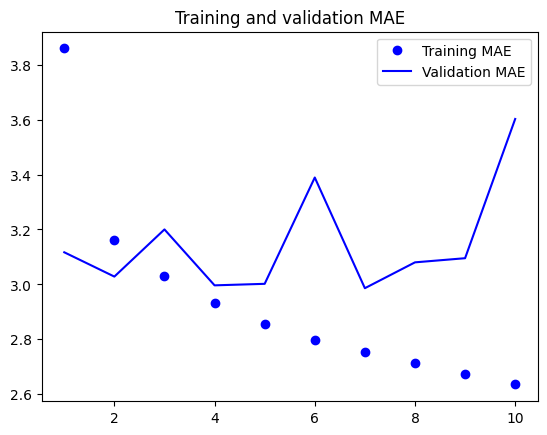

In [41]:

loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

there is a class of DL models which help solve timeseries tasks with causality and order.
among the class of recurrent neural network models, LSTM model is the king

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 41.4385 - mae: 4.6926 - val_loss: 12.6325 - val_mae: 2.6850
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 10.9405 - mae: 2.5593 - val_loss: 9.5253 - val_mae: 2.4107
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 9.6805 - mae: 2.4239 - val_loss: 9.4312 - val_mae: 2.4026
Epoch 4/10
819/819 [==============================] - 19s 23ms/step - loss: 9.0317 - mae: 2.3457 - val_loss: 9.7069 - val_mae: 2.4163
Epoch 5/10
819/819 [==============================] - 19s 23ms/step - loss: 8.5439 - mae: 2.2820 - val_loss: 9.8469 - val_mae: 2.4280
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 8.2080 - mae: 2.2381 - val_loss: 10.0036 - val_mae: 2.4563
Epoch 7/10
819/819 [==============================] - 19s 23ms/step - loss: 7.9373 - mae: 2.2020 - val_loss: 9.8706 - val_mae: 2.4318
Epoch 8/10
819/819 [==============================] - 19s 

In [44]:
model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 10.9462 - mae: 2.6052
Test MAE: 2.61


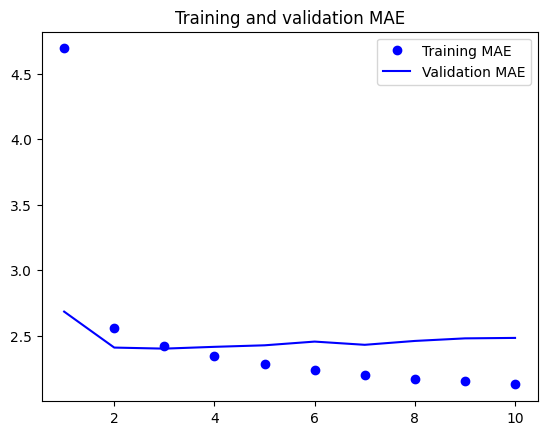

In [45]:
loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

with LSTM, the mae is reduced to 2.61 which is better than the baseline we created.
even the plot looks much better with trainign and validation plots converging to a lower value.

understanding RNNs (Recurrent neural networks)

Neural nets such as convnets and densely connected neural nets have no memory or internal state. They accept a bunch of inputs, process them through sequential layers and dump the outputs. There is no internal state and inputs are processed independently.

Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in. Recurrent neural nets try to model this behaviour in a much more simplified way.
it maintains an internal state based on inputs it has received and relative to what it has seen
instead of treating the data as a single tensor and using that to predict the output, rnn has a for loop which iterates over the sequence elements .


Numpy implementation of a simple RNN

In [2]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps,input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input in inputs:
    output_t = np.tanh(np.dot(W,input) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)


In [6]:
from tensorflow import keras
from keras import layers

In [7]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16) (inputs)

2024-03-30 13:48:47.122415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-30 13:48:47.122438: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-30 13:48:47.122442: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-30 13:48:47.122499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 13:48:47.122536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


By specifying the timesteps as None,you enable the model to process variable sequence lengths.if the timesteps size is known, then the timesteps number can be given. this will enable model optimizations. 

An RNN layer that returns only its last output step

In [8]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False) (inputs)
print(outputs.shape)

(None, 16)


Vanilla RNNs suffer from vanishing gradient problem -> as more and more timestep data is processed, it eventually loses information of older timesteps. to prevent this requires a way to transport timesteps of data without the gradients getting lost. i.e create a parallel channel for timesteps of data without processing [like residual networks in temporal space]. LSTM [Long short term memory] a variant of RNN was introduced to solve the problem.

In LSTM, we have an additional parameter c_t, the carry. this helps the model forget data which is irrelevant or prevent the values in all the timesteps from being processed. 
Though we could get philosophical and attribute certain qualities to certain parts of the model, in the end, it is an end2end model where different weights are learned in different parts to solve the task at hand. The design of the architecture is done with human engineer's intuition, experience or optimization algorithms like genetic algorithms or RL algorithms.

Pseudo code details for LSTM
output = activation(dot(state_t, U0) + dot(input_t,W0) + dot(c_t, V0) + b0)
i_t = activation(dot(state_t, Ui) + dot(input_t,Wi) +  bi)
f_t = activation(dot(state_t, Uf) + dot(input_t,Wf) +  bf)
k_t = activation(dot(state_t, Uk) + dot(input_t,Wk) +  bk)

c_t+1 = i_t*k_t + c_t*f_t

Dropout for RNNS : the dropout used in RNN is slightly different from dropout used in regular nn. the same dropout mask is to be used at every timestep for error to propagat correctly in the model, else with random dropout masks,we see a distortion in error propogation. also, there is a dropout added to the recurrent internal recurrent units.

In [23]:
print(sequence_length, raw_data.shape)

120 (420451, 14)


RNN runtime performance
Recurrent models with very few parameters, like the ones in this chapter, tend to be significantly faster on a multicore CPU than on GPU, because they only involve small matrix multiplications, and the chain of multiplications is not well paralleliz- able due to the presence of a for loop. But larger RNNs can greatly benefit from a GPU runtime.
When using a Keras LSTM or GRU layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm (I mentioned these in the previous chap- ter). As usual, cuDNN kernels are a mixed blessing: they’re fast, but inflexible—if you try to do anything not supported by the default kernel, you will suffer a dramatic slow- down, which more or less forces you to stick to what NVIDIA happens to provide. For instance, recurrent dropout isn’t supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same).

As a way to speed up your RNN layer when you can’t use cuDNN, you can try unrolling it. Unrolling a for loop consists of removing the loop and simply inlining its content N times. In the case of the for loop of an RNN, unrolling can help TensorFlow opti- mize the underlying computation graph. 

In [34]:
with tf.device('/cpu:0'):
    inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
    x = layers.LSTM(32,recurrent_dropout=0.25) (inputs)
    x = layers.Dropout(0.5) (x)
    outputs = layers.Dense(1) (x)
    model = keras.Model(inputs = inputs, outputs = outputs)
    callbacks = keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",save_best_only=True)
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    history = model.fit(train_dataset,
                            epochs=50,
                            validation_data=val_dataset,
                            callbacks=callbacks)


Epoch 1/50
819/819 [==============================] - 59s 71ms/step - loss: 27.5640 - mae: 3.8721 - val_loss: 9.6927 - val_mae: 2.4191
Epoch 2/50
  1/819 [..............................] - ETA: 1:52 - loss: 14.5010 - mae: 2.9029

/Users/divyeshkanagavel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 58s 71ms/step - loss: 14.7417 - mae: 2.9840 - val_loss: 9.3026 - val_mae: 2.3672
Epoch 3/50
819/819 [==============================] - 59s 72ms/step - loss: 13.9536 - mae: 2.8990 - val_loss: 9.2903 - val_mae: 2.3641
Epoch 4/50
819/819 [==============================] - 60s 73ms/step - loss: 13.3924 - mae: 2.8386 - val_loss: 9.4702 - val_mae: 2.3806
Epoch 5/50
819/819 [==============================] - 59s 72ms/step - loss: 12.9054 - mae: 2.7870 - val_loss: 9.6106 - val_mae: 2.3940
Epoch 6/50
819/819 [==============================] - 57s 70ms/step - loss: 12.5180 - mae: 2.7459 - val_loss: 9.3997 - val_mae: 2.3748
Epoch 7/50
819/819 [==============================] - 57s 70ms/step - loss: 12.1714 - mae: 2.7082 - val_loss: 9.3358 - val_mae: 2.3683
Epoch 8/50
819/819 [==============================] - 57s 70ms/step - loss: 11.9495 - mae: 2.6828 - val_loss: 9.7090 - val_mae: 2.4054
Epoch 9/50
819/819 [==============================] - 59s 72ms/ste

In [36]:
model = keras.models.load_model("jena_lstm_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 191s 472ms/step - loss: 10.4920 - mae: 2.5511
Test MAE: 2.55


we are using cpu instead of gpu because this is not a big example, and cudnn kernel are not optimized for recurrent neural networks with recurrent dropout -> it falls back to generic gpu kernel .this model does not contain manay matrix multiplications to see speedup and contains for loop -> this can be fastened by unrolling it, but that introduces memory constraints.

with dropout, the problem of overfitting is solved.To increase the capactity of RNNs, the layers are stacked together and the model is let to overfit, then the best model is selected just before overfitting kicked in. 
There is another variant of RNN called GRU (Gated Recurrent unit) . It is a simpler and streamlined version of LSTM with fewer trainable parameters.

zt  = sigma(Wzxt + Uzht-1 + bz) #update gate vector
rt = sigma(Wrxt + Urht-1 + br)  # reset gate vector
htcap = phi(Whxt + Uh(rt dot ht-1) + bh)
ht = (1-zt) dot ht-1 + zt dot htcap


In [ ]:
'''inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
            keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                            save_best_only=True)]'''

#This is a stacked Gated Recurrent unit used . notice the return_sequences=True in the first
#layer so that the same shape timeseries output goes as input to second GRU
#not running this since cudnn kernel is not present and it it taking a lot of time to run 50 epochs

Bi-directional RNNs [state of the art for text related tasks before transformers]
gives better performance than vanilla RNNs in many tasks especially natural language related tasks like machine translation , next token prediction

it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

In [40]:
train_dataset_bidirectional = keras.utils.timeseries_dataset_from_array(
    raw_data[::-1,:][:-delay],
    temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle=True,
    sequence_length = sequence_length,
    batch_size=batch_size,
    start_index = 0,
    end_index = num_train_samples
)

In [41]:
val_dataset_bidirectional = keras.utils.timeseries_dataset_from_array(
    raw_data[::-1,:][:-delay],
targets=temperature[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + val_train_samples)

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_rnn_birectional.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 28s 32ms/step - loss: 27.6485 - mae: 3.7565 - val_loss: 10.3596 - val_mae: 2.4916
Epoch 2/10
  3/819 [..............................] - ETA: 21s - loss: 9.9138 - mae: 2.4705  

/Users/divyeshkanagavel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 26s 32ms/step - loss: 9.5699 - mae: 2.4086 - val_loss: 9.6932 - val_mae: 2.4105
Epoch 3/10
819/819 [==============================] - 27s 33ms/step - loss: 8.6080 - mae: 2.2826 - val_loss: 9.7306 - val_mae: 2.4078
Epoch 4/10
819/819 [==============================] - 27s 33ms/step - loss: 7.9864 - mae: 2.2031 - val_loss: 10.1284 - val_mae: 2.4545
Epoch 5/10
819/819 [==============================] - 27s 33ms/step - loss: 7.6063 - mae: 2.1517 - val_loss: 9.9906 - val_mae: 2.4454
Epoch 6/10
819/819 [==============================] - 26s 32ms/step - loss: 7.3136 - mae: 2.1129 - val_loss: 10.6493 - val_mae: 2.5076
Epoch 7/10
819/819 [==============================] - 26s 32ms/step - loss: 7.0619 - mae: 2.0733 - val_loss: 10.5410 - val_mae: 2.4901
Epoch 8/10
819/819 [==============================] - 26s 32ms/step - loss: 6.8419 - mae: 2.0373 - val_loss: 10.3432 - val_mae: 2.4738
Epoch 9/10
819/819 [==============================] - 26s 32ms/step -

In [46]:
model = keras.models.load_model("jena_rnn_birectional.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 6s 14ms/step - loss: 10.8838 - mae: 2.5808
Test MAE: 2.58


bidirectional rnn is useful in natural language more than temperature forecasting
here the order of inputs is very important (the most recent timestep data is more important than older timestep data) In case of bidirectional we take both chronological data and antichronological data and merge it .the antichronological data does not perform well at all.so the merge's performance is not better than plain LSTM

In case of natural language, the position of a word is important but not the order of words. in fact having another useful but different way of looking at data adds to the search space improves the model's performance since it is introduced with fresher data [like data augmentation in convnets]

Some other stuff to try to improve the performance of the model:
1. adjust the number of recurrent units in LSTM layers or GRU layers
2. change the optimizer and the learning rates
3. Stack different number of rnn units
4. adjust dropout
5. do feature engineering on the inputs -> change the sequence length , sampling rate etc